In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [ ]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend
# text svg

'notebook'

In [ ]:
task = [
    'PhonemeSequence',
    'SentenceRep',
    'TIMIT'
]
ref='bipolar'


stats_paths = []
stats_paths.extend(
    BIDSPath(
        root=f'../results/{t}({ref})',
        datatype='HGA',
        suffix='coord',
        check=False,
    ).match()
    for t in task
)

stats_paths = np.concatenate(stats_paths).tolist()

coords = []
for path in tqdm(stats_paths):
    df = pd.read_csv(path)
    coords.append(df)
    
coords = pd.concat(coords)

# rename INS to 'Insula'
coords.loc[coords.roi == 'INS', 'roi'] = 'Insula'

# combine HG to STG
coords.loc[coords.roi == 'HG', 'roi'] = 'STG'

# rename CG to Cingulate cortex
coords.loc[coords.roi == 'PrG', 'roi'] = 'SMC'
coords.loc[coords.roi == 'PoG', 'roi'] = 'SMC'
coords.loc[coords.roi == 'Subcentral', 'roi'] = 'SMC'

coords.head()

100%|██████████| 343/343 [00:01<00:00, 323.35it/s]


,channel,x,y,z,HGA,significant,subject,task,band,description,phase,label,roi,hemi
0,D0019_ROG1-2,20.731562,-95.433053,-4.406237,-0.042141,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
1,D0019_ROG2-3,18.712896,-94.417750,6.523434,0.028593,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
2,D0019_ROG3-4,17.039880,-94.822626,17.317047,0.061983,True,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
3,D0019_ROG4-5,16.298644,-91.860079,29.446276,0.060467,True,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_G_occipital_sup,sOccG,R
4,D0019_ROG5-6,13.397947,-84.402838,39.447554,0.018777,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_G_occipital_sup,sOccG,R


# All SMC/STG/Insula electrodes 

In [43]:
# take unique electrode out
coords_unique = coords[coords.roi.isin(['Insula', 'STG', 'SMC'])].drop_duplicates(subset=['channel'])
print('Number of electrodes: ', coords_unique.shape[0])

Number of electrodes:  838


Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-04 15:37:10.167 (4021.248s) [    7FBD0C700440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1770a760): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-04 15:37:10.206 (4021.287s) [    7FBD0C700440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1520f190): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

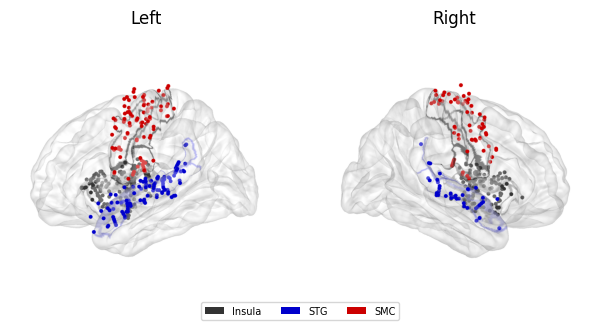

In [46]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree

# 定义三个ROI的颜色
roi_colors = {
    'Insula': (0.2, 0.2, 0.2),    # 深灰色
    'STG': (0.0, 0.0, 0.8),       # 蓝色
    'SMC': (0.8, 0.0, 0.0),       # 红色
}

# 读取labels用于过滤电极
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# 构建每个ROI对应的label顶点集合
def get_roi_vertices(labels, roi_name, hemi):
    """获取指定ROI在指定半球的所有顶点"""
    vertices = set()
    for lab in labels:
        name = lab.name
        if lab.hemi != hemi:
            continue
        # Insula
        if roi_name == 'Insula' and 'ins' in name.lower():
            vertices.update(lab.vertices)
        # STG
        elif roi_name == 'STG' and 'G_temp_sup' in name:
            vertices.update(lab.vertices)
        # SMC
        elif roi_name == 'SMC':
            smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
            if any(k in name for k in smc_keys):
                vertices.update(lab.vertices)
    return vertices

# 预先计算每个半球每个ROI的顶点
lh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'lh') for roi in roi_colors.keys()}
rh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'rh') for roi in roi_colors.keys()}

# 创建Brain对象 - 使用pial表面
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.95, 0.95, 0.95), alpha=0.3, size=(600*cm, 600*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.3, size=(600*cm, 600*cm)
)

cord = coords_unique[['x', 'y', 'z']].values
rois = coords_unique['roi'].values

mask_lh = cord[:, 0] < 0  # x < 0 为左半球
mask_rh = cord[:, 0] > 0  # x > 0 为右半球

# 加载pial表面数据用于过滤
lh_pial_path = f"{recon_dir}/fsaverage/surf/lh.pial"
lh_coords_pial, _ = mne.read_surface(lh_pial_path)
lh_tree = cKDTree(lh_coords_pial)

rh_pial_path = f"{recon_dir}/fsaverage/surf/rh.pial"
rh_coords_pial, _ = mne.read_surface(rh_pial_path)
rh_tree = cKDTree(rh_coords_pial)

# 处理左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_rois = rois[mask_lh]
    _, lh_indices = lh_tree.query(lh_cord)  # 找最近顶点用于过滤
    
    # 过滤：只保留在对应ROI label内的电极
    valid_mask = np.zeros(len(lh_cord), dtype=bool)
    for i, (idx, roi) in enumerate(zip(lh_indices, lh_rois)):
        if idx in lh_roi_vertices[roi]:
            valid_mask[i] = True
    
    # 按ROI分组绘制不同颜色的电极（使用原始坐标）
    for roi, color in roi_colors.items():
        roi_mask = (lh_rois == roi) & valid_mask
        if roi_mask.any():
            cloud = pv.PolyData(lh_cord[roi_mask])  # 直接使用原始坐标
            lh_brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=20,
                color=color,
                lighting=False,
                smooth_shading=False,
                opacity=1,
            )

# 处理右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_rois = rois[mask_rh]
    _, rh_indices = rh_tree.query(rh_cord)  # 找最近顶点用于过滤
    
    # 过滤：只保留在对应ROI label内的电极
    valid_mask = np.zeros(len(rh_cord), dtype=bool)
    for i, (idx, roi) in enumerate(zip(rh_indices, rh_rois)):
        if idx in rh_roi_vertices[roi]:
            valid_mask[i] = True
    
    # 按ROI分组绘制不同颜色的电极（使用原始坐标）
    for roi, color in roi_colors.items():
        roi_mask = (rh_rois == roi) & valid_mask
        if roi_mask.any():
            cloud = pv.PolyData(rh_cord[roi_mask])  # 直接使用原始坐标
            rh_brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=20,
                color=color,
                lighting=False,
                smooth_shading=False,
                opacity=1,
            )

# 添加ROI边界
for lab in labels:
    name = lab.name

    # Insula
    if 'ins' in name.lower():
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)

    if ('G_temp_sup' in name):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)

    smc_keys = [
        'G_precentral',
        'G_postcentral',
        'G_and_S_subcentral',
    ]
    if any(k in name for k in smc_keys):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color='black', alpha=0.7)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color='black', alpha=0.7)

for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=400)
    brain._renderer.plotter.window_size = [1400, 1400]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
ax1.imshow(lh_brain.screenshot(mode="rgb"))
ax1.axis("off")
ax1.set_title("Left")

ax2.imshow(rh_brain.screenshot(mode="rgb"))
ax2.axis("off")
ax2.set_title("Right")

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=roi) for roi, color in roi_colors.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=7)

# 关闭 Brain 对象
lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.show()

Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-04 15:26:18.985 (3370.066s) [    7FBD0C700440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0xf5b4060): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-04 15:26:19.031 (3370.112s) [    7FBD0C700440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x184c0fe0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: e

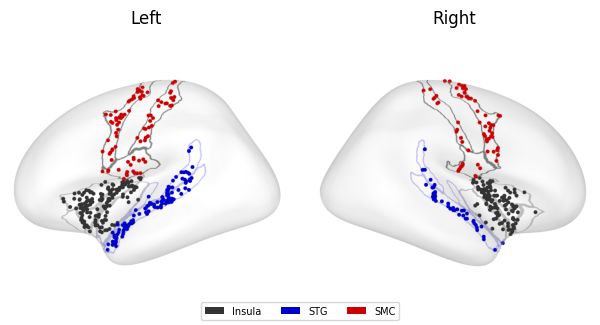

In [44]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree

# 定义三个ROI的颜色
roi_colors = {
    'Insula': (0.2, 0.2, 0.2),    # 深灰色
    'STG': (0.0, 0.0, 0.8),       # 蓝色
    'SMC': (0.8, 0.0, 0.0),       # 红色
}

# 读取labels用于过滤电极
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# 构建每个ROI对应的label顶点集合
def get_roi_vertices(labels, roi_name, hemi):
    """获取指定ROI在指定半球的所有顶点"""
    vertices = set()
    for lab in labels:
        name = lab.name
        if lab.hemi != hemi:
            continue
        # Insula
        if roi_name == 'Insula' and 'ins' in name.lower():
            vertices.update(lab.vertices)
        # STG
        elif roi_name == 'STG' and 'G_temp_sup' in name:
            vertices.update(lab.vertices)
        # SMC
        elif roi_name == 'SMC':
            smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
            if any(k in name for k in smc_keys):
                vertices.update(lab.vertices)
    return vertices

# 预先计算每个半球每个ROI的顶点
lh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'lh') for roi in roi_colors.keys()}
rh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'rh') for roi in roi_colors.keys()}

# 创建Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="lh", background="white", show=False,
    cortex=(0.95, 0.95, 0.95), alpha=0.3, size=(600*cm, 600*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.3, size=(600*cm, 600*cm)
)

cord = coords_unique[['x', 'y', 'z']].values
rois = coords_unique['roi'].values

mask_lh = cord[:, 0] < 0  # x < 0 为左半球
mask_rh = cord[:, 0] > 0  # x > 0 为右半球

# 加载表面数据
lh_pial_path = f"{recon_dir}/fsaverage/surf/lh.pial"
lh_infl_path = f"{recon_dir}/fsaverage/surf/lh.inflated"
lh_coords_pial, _ = mne.read_surface(lh_pial_path)
lh_coords_infl, _ = mne.read_surface(lh_infl_path)
lh_tree = cKDTree(lh_coords_pial)

rh_pial_path = f"{recon_dir}/fsaverage/surf/rh.pial"
rh_infl_path = f"{recon_dir}/fsaverage/surf/rh.inflated"
rh_coords_pial, _ = mne.read_surface(rh_pial_path)
rh_coords_infl, _ = mne.read_surface(rh_infl_path)
rh_tree = cKDTree(rh_coords_pial)

# 处理左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_rois = rois[mask_lh]
    _, lh_indices = lh_tree.query(lh_cord)
    lh_cord_on_infl = lh_coords_infl[lh_indices]
    
    # 过滤：只保留在对应ROI label内的电极
    valid_mask = np.zeros(len(lh_cord), dtype=bool)
    for i, (idx, roi) in enumerate(zip(lh_indices, lh_rois)):
        if idx in lh_roi_vertices[roi]:
            valid_mask[i] = True
    
    # 按ROI分组绘制不同颜色的电极
    for roi, color in roi_colors.items():
        roi_mask = (lh_rois == roi) & valid_mask
        if roi_mask.any():
            cloud = pv.PolyData(lh_cord_on_infl[roi_mask])
            lh_brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=20,
                color=color,
                lighting=False,
                smooth_shading=False,
                opacity=1,
            )

# 处理右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_rois = rois[mask_rh]
    _, rh_indices = rh_tree.query(rh_cord)
    rh_cord_on_infl = rh_coords_infl[rh_indices]
    
    # 过滤：只保留在对应ROI label内的电极
    valid_mask = np.zeros(len(rh_cord), dtype=bool)
    for i, (idx, roi) in enumerate(zip(rh_indices, rh_rois)):
        if idx in rh_roi_vertices[roi]:
            valid_mask[i] = True
    
    # 按ROI分组绘制不同颜色的电极
    for roi, color in roi_colors.items():
        roi_mask = (rh_rois == roi) & valid_mask
        if roi_mask.any():
            cloud = pv.PolyData(rh_cord_on_infl[roi_mask])
            rh_brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=20,
                color=color,
                lighting=False,
                smooth_shading=False,
                opacity=1,
            )

# 添加ROI边界
for lab in labels:
    name = lab.name

    # Insula
    if 'ins' in name.lower():
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)

    if ('G_temp_sup' in name):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)

    smc_keys = [
        'G_precentral',
        'G_postcentral',
        'G_and_S_subcentral',
    ]
    if any(k in name for k in smc_keys):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color='black', alpha=0.7)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color='black', alpha=0.7)

for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=400)
    brain._renderer.plotter.window_size = [1400, 1400]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
ax1.imshow(lh_brain.screenshot(mode="rgb"))
ax1.axis("off")
ax1.set_title("Left")

ax2.imshow(rh_brain.screenshot(mode="rgb"))
ax2.axis("off")
ax2.set_title("Right")

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=roi) for roi, color in roi_colors.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=7)

# 关闭 Brain 对象
lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.show()